# Feature: beam pattern taper correction (`removeTaper`)

This notebook covers the development of a method to determine (and correct for) the beam pattern taper that can be observed in DIDSON data.

## Dependencies

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob 
from skimage.io import imread 


In [2]:
# test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-1/*raw.png') 
test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/2016-07-19.11/0182/*raw.png') 
print 'Test set size:',len(test_image_list)

# two sets of images observing open water (no objects) with window range from 2.25 to 11.25m (9m window)
bg_image_list_1 = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print 'Background set 1 size:', len(bg_image_list_1)
bg_image_list_2 = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-3/*raw.png') # 
print 'Background set 2 size:',len(bg_image_list_2)

Test set size: 98
Background set 1 size: 116
Background set 2 size: 270


In [3]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Beams:',didson.num_beams
print 'Range bins:',didson.num_bins
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise

Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.0199794887389 , y: 0.01998400879
Beams: 96
Range bins: 512
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.01


1.0
0.0962243596556


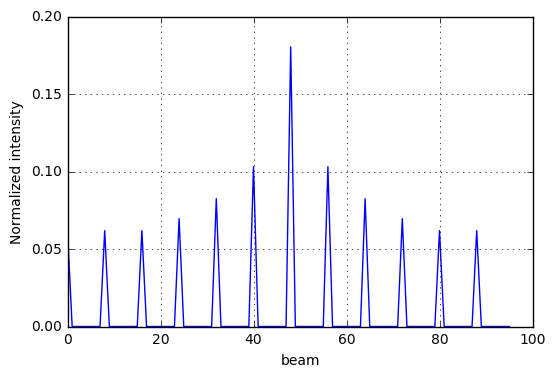

In [4]:
psf = didson.psf[0,:]
plt.figure()
plt.plot(psf)
plt.grid()
plt.xlabel('beam')
plt.ylabel('Normalized intensity')
# plt.savefig("psf.png",transparent=True,pad_inches=0.0)
print np.sum(psf)
print np.sum(psf**2)

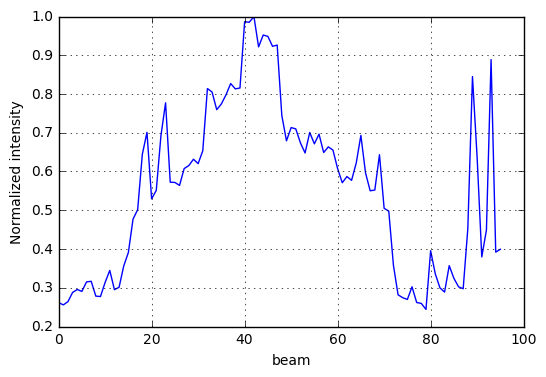

In [5]:
plt.figure()
plt.plot(didson.taper)
plt.grid()
plt.xlabel('beam')
plt.ylabel('Normalized intensity')
plt.savefig("psf.png",transparent=True,pad_inches=0.0)

## 1. Taper correction

This function computes the beam pattern taper from a set of scans (after deconvolving them).

In [6]:
def computeBPTaper(image_list, sonar,deconv=True):
    N = len(image_list)
    taper = np.zeros(sonar.num_beams, dtype = np.float64)
    for i in range(0,N):
        ping = imread(image_list[i],as_grey=True)
        ping = ping.astype(np.float64)
#         print 'ping',i
#         print '    range:',np.amin(ping[:]),'-',np.amax(ping[:])
#         print '    mean:', np.mean(ping[:])
#         print '    var:',np.var(ping[:])
        
        # deconvolve first
        if(deconv):
            ping = sonar.deconvolve(ping) 
        
        taper += np.sum(ping, axis = 0)
        
    taper/=(N+0.0)
    taper/=np.amax(taper)
    
    return taper.astype(dtype=ping.dtype)

Test the function on the background image sets.

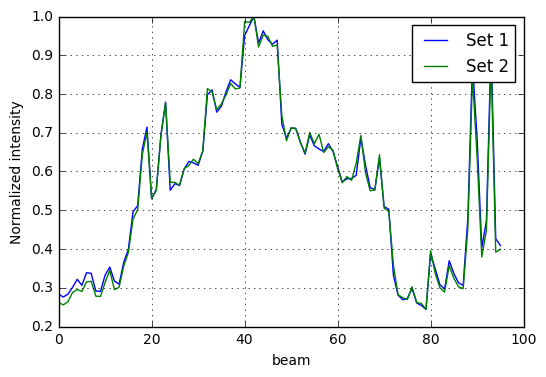

In [7]:
# didson.noise=.05
tp1 = computeBPTaper(bg_image_list_1, didson)
tp2 = computeBPTaper(bg_image_list_2, didson)

plt.figure()
plt.plot(range(0,didson.num_beams),tp1)
plt.plot(range(0,didson.num_beams),tp2)
plt.grid()
plt.xlabel('beam')
plt.ylabel('Normalized intensity')
# plt.title('Normalized beam pattern taper')
plt.legend(['Set 1','Set 2'])
plt.savefig("bpt.png",transparent=True,pad_inches=0.0)


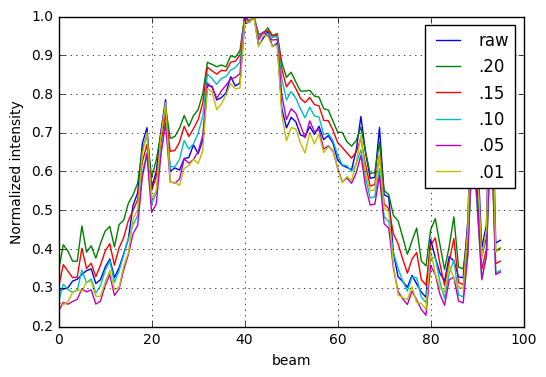

In [8]:
tp_raw = computeBPTaper(bg_image_list_2, didson,False)
didson.noise=.2
tp_020 = computeBPTaper(bg_image_list_2, didson)
didson.noise=.15
tp_015 = computeBPTaper(bg_image_list_2, didson)
didson.noise=.1
tp_010 = computeBPTaper(bg_image_list_2, didson)
didson.noise=.05
tp_005 = computeBPTaper(bg_image_list_2, didson)
didson.noise=.01
tp_001 = computeBPTaper(bg_image_list_2, didson)

plt.figure()
plt.plot(range(0,didson.num_beams),tp_raw)
plt.plot(range(0,didson.num_beams),tp_020)
plt.plot(range(0,didson.num_beams),tp_015)
plt.plot(range(0,didson.num_beams),tp_010)
plt.plot(range(0,didson.num_beams),tp_005)
plt.plot(range(0,didson.num_beams),tp_001)

plt.grid()
plt.xlabel('beam')
plt.ylabel('Normalized intensity')
# plt.title('Normalized beam pattern taper')
plt.legend(['raw','.20','.15','.10','.05','.01'])
plt.savefig("bpt.png",transparent=True,pad_inches=0.0)

We can now create a function that removes the taper from a given ping.

In [9]:
def removeBPTaper(ping, taper):
    taper = np.tile(taper, (ping.shape[0],1))
    ping2 = ping.astype(np.float64)
    ping2/=taper
    # renormalization
#     if ping2.max() > 1.0:
#         ping2 =(1.0/ping2.max())*ping2
#     else:
#         ping2 =(np.max(ping)/np.max(ping2))*ping2
    ping2 =(ping.max()/ping2.max())*ping2
    return ping2.astype(dtype=ping.dtype)

The following function computes the histogram of a ping - it is useful when trying to understand the effect of bem pattern taper on the intensity distribution of a ping.

In [10]:
def computeHist(ping):
    bins = np.arange(0,256)
    h = np.histogram(ping, bins)
    return (bins, (h[0]+0.0)/np.sum(h[0])) 

### Test image

This block retrieves a random image from one of the sets, and corrects for impulse response and beam pattern taper. The two versions of the image (before and after correction) are presented, as are the corresponding histograms.

selecting image 8469
Resolution
Desired: 0.02 , x: 0.0200313888031 , y: 0.0200287157448
Beams: 96
Range bins: 512
Field of view: 0.502654824574
Range: 1.5  -  6.0 m.
Noise: 0.01
ping0
    range: 0 255
    mean: 6.89194742839
    var: 224.694847265
    sum: 338753
    sum2: 1579061
ping1
    range: 0.0 255.0
    mean: 4.64673921088
    var: 165.825607464
    sum: 228396.525693
    sum2: 9211959.34964
ping2
    range: 0.0 255.0
    mean: 3.42430455305
    var: 89.9773490225
    sum: 168311.417392
    sum2: 4998916.21206


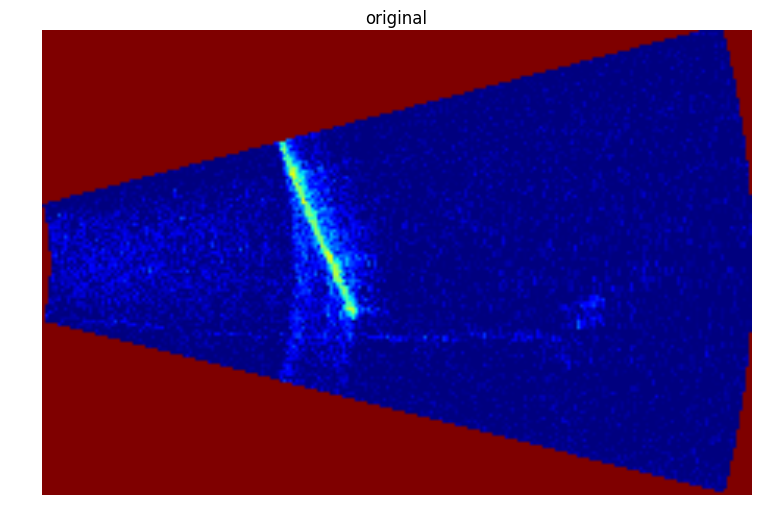

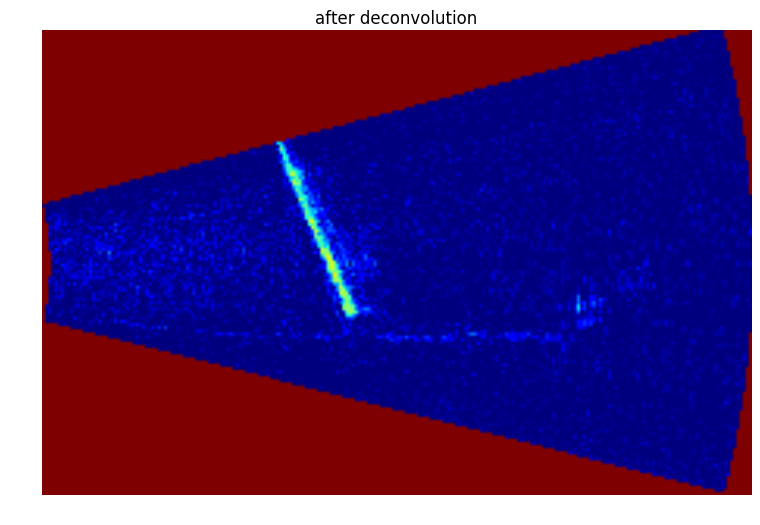

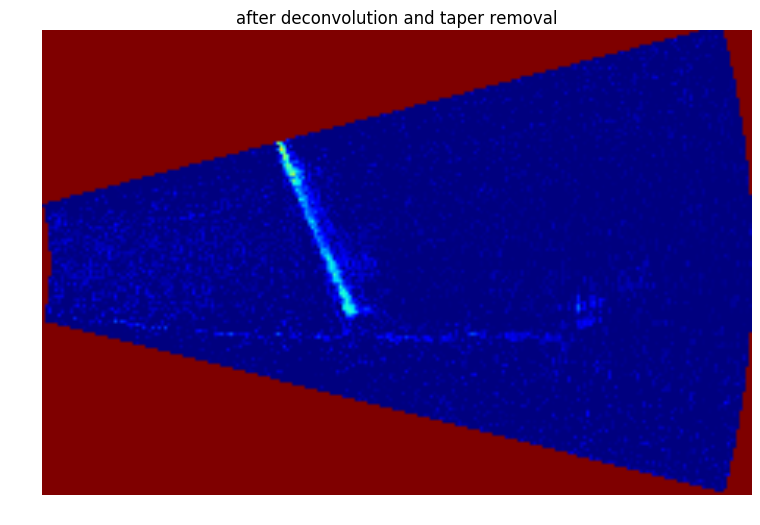

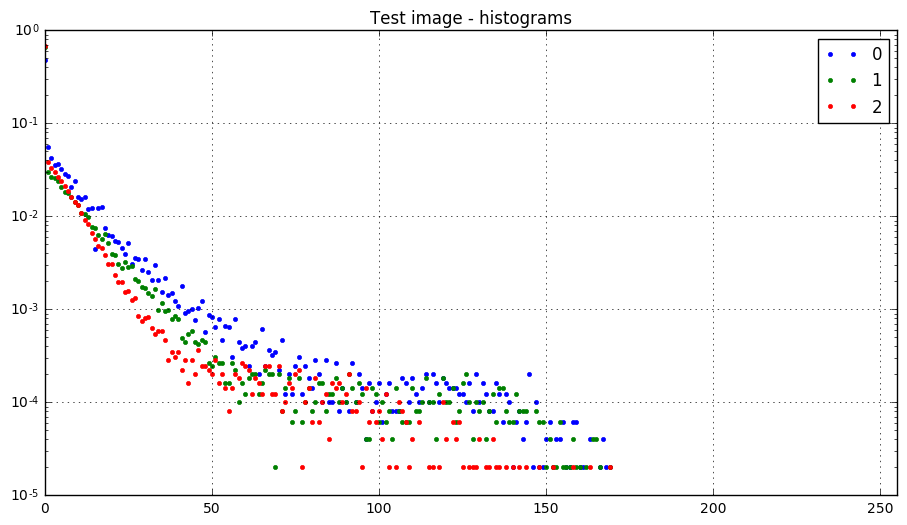

In [19]:
# image_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-07-31.00_reprocess/pings/raw/*.png') 
image_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-08-01.00_reprocess/pings/raw/*.png') 
cfg_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-08-01.00_reprocess/pings/raw/*.json')

idx = np.random.randint(0,len(image_list))
# idx = 13445
print 'selecting image',idx
didson.loadConfig(cfg_list[idx])
# didson.noise = .025
print 'Beams:',didson.num_beams
print 'Range bins:',didson.num_bins
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise

ping0 = imread(image_list[idx],as_grey=True)
(b, h0) = computeHist(ping0)

ping1 = didson.deconvolve(ping0)
# ping1[ping1<0]=0
# ping1*=(ping0.max()+0.0)/ping1.max()
# ping1*=(np.sum(ping0[:])+0.0)/np.sum(ping1[:])
(b, h1) = computeHist(ping1)

ping2 = removeBPTaper(ping1, tp_020)
(b, h2) = computeHist(ping2)

colormap='gray'
colormap='jet'
fs = (11,6)
bg_value = 255.0

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping0,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('original')
plt.axis('off')
plt.savefig("ping.png",transparent=True,pad_inches=0.0)

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping1,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('after deconvolution')
plt.axis('off')
plt.savefig("ping_deconv.png",transparent=True,pad_inches=0.0)

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping2,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('after deconvolution and taper removal')
plt.axis('off')
plt.savefig("ping_deconv_taper.png",transparent=True,pad_inches=0.0)

plt.figure(figsize=(11,6))
plt.plot(b[:-1],h0,'.')
plt.plot(b[:-1],h1,'.')
plt.plot(b[:-1],h2,'.')
plt.yscale('log')
plt.grid()
plt.xlim([0,255])
plt.ylim([1e-5,1e0])
plt.legend(('0','1','2'))
plt.title('Test image - histograms')

print 'ping0'
print '    range:',ping0.min(), ping0.max()
print '    mean:',np.mean(ping0[:])
print '    var:',np.var(ping0[:])
print '    sum:',np.sum(ping0[:])
print '    sum2:',np.sum(ping0[:]**2)

print 'ping1'
print '    range:',ping1.min(), ping1.max()
print '    mean:',np.mean(ping1[:])
print '    var:',np.var(ping1[:])
print '    sum:',np.sum(ping1[:])
print '    sum2:',np.sum(ping1[:]**2)

print 'ping2'
print '    range:',ping2.min(), ping2.max()
print '    mean:',np.mean(ping2[:])
print '    var:',np.var(ping2[:])
print '    sum:',np.sum(ping2[:])
print '    sum2:',np.sum(ping2[:]**2)

## 2. Attenuation correction

### Test image

## Noise distribution

In [ ]:
xdata = b[:-1]
ydata = h3

s0 = np.ones_like(h3)
s0 = 1.0*ydata
s0[s0<=0] = 1e3

p0,v0 = curve_fit(stats.expon.pdf, xdata, ydata, p0=[0,5],sigma=s0)
print p0
print np.sum(stats.expon.pdf(xdata, loc=p0[0], scale=p0[1]))
print ydata[0],stats.expon.pdf(0, loc=p0[0], scale=p0[1])

print 'fit:',np.sum(stats.expon.pdf(xdata, loc=p0[0], scale=p0[1]))

plt.figure(figsize=(12,12))
plt.plot(xdata, ydata)
plt.plot(xdata, stats.expon.pdf(xdata, loc=p0[0], scale=p0[1]))
plt.plot(xdata, stats.expon.pdf(xdata,loc=-7, scale=5))
plt.plot(xdata, stats.expon.pdf(xdata,loc=-7, scale=5) + stats.expon.pdf(xdata, loc=p0[0], scale=p0[1]))

plt.xlim([0 ,255])
plt.ylim([1e-6, 1e0])
plt.yscale('log')
plt.grid(b=True, which='both')
plt.legend(('test sample','noise estimate','target estimate','mixture'))
plt.show()

# plot difference between measured and model - should be flat (white)
plt.figure(figsize=(12,6))
plt.plot(xdata, ydata - stats.expon.pdf(xdata,loc=-7, scale=5) + stats.expon.pdf(xdata, loc=p0[0], scale=p0[1]))
plt.xlim([0 ,255])
plt.ylim([1e-6, 1e0])
plt.yscale('log')
plt.grid(b=True, which='both')
plt.show()

In [ ]:
def computeSetHist(image_list, sonar, taper, attenuation):
    N = len(image_list)
    h = np.zeros(255)
    bins = np.arange(0,256)
    
    for idx in range(0,N):
        ping = imread(image_list[idx],as_grey=True)
        ping = ping.astype(np.float64)
        ping = sonar.deconvolve(ping)
        ping = removeBPTaper(ping, taper)
        ping = removeAttenuation(ping, attenuation)
        bp, hp = computeHist(ping)
        h+=hp
        
    h/=(N+0.0)
    return (bins, h)

In [ ]:
(bins1, h1) = computeSetHist(bg_image_list_1, didson, tp1, at1)
h1[0]=0.05
s0 = 1.0*h1
s0[s0<=0] = 1e3
p1,v1 = curve_fit(stats.expon.pdf, bins1[:-1], h1, p0=[0,6],sigma=s0)
print p1

# (bins2, h2) = computeSetHist(bg_image_list_2, didson, tp2, at2)
# s0 = 1.0*h2
# s0[s0<=0] = 1e3
# p2,v2 = curve_fit(stats.expon.pdf, bins2[:-1], h2, p0=[-5,5],sigma=s0)
# print p2



# test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/2016-07-19.11/0003/*raw.png') 
test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/2016-07-19.11/fish/*raw.png') 
# (bins3a, h3a) = computeSetHist(test_image_list, didson, tp1, at1)
# (bins3b, h3b) = computeSetHist(test_image_list, didson, tp2, at2)
# (bins1, h1) = computeSetHist(bg_image_list_1, didson, np.ones(96), np.ones(512))
# (bins2, h2) = computeSetHist(bg_image_list_2, didson, np.ones(96), np.ones(512))

plt.figure(figsize=(8,8))
plt.plot(bins1[:-1], h1)
plt.plot(bins1[:-1],stats.expon.pdf(bins1[:-1],loc=p1[0],scale=p1[1]))
plt.plot(bins1[:-1],np.abs(h1 - stats.expon.pdf(bins1[:-1], loc=p1[0],scale=p1[1])))

# plt.plot(bins2[:-1], h2)
# plt.plot(bins2[:-1],stats.expon.pdf(bins2[:-1],loc=p2[0],scale=p2[1]))
# plt.plot(bins2[:-1],np.abs(h2 - stats.expon.pdf(bins2[:-1],loc=p2[0],scale=p2[1])))

# plt.plot(bins2[:-1], h2)
# plt.plot(bins3a[:-1], h3a)
# plt.plot(bins3b[:-1], h3b)

plt.yscale('log')
plt.grid(b=True, which='both')
plt.xlim([0 ,100])
plt.ylim([1e-7, 1e0]) # 1/49152 ~ 1e-5
plt.legend(('bg1','bg1-est','bg1-diff','bg2','bg2-est','bg2-diff'))

In [ ]:
print h1[0:10]
print np.sum(h1[1:-1])

TODO:
* re-do ping-to-disk (addresses 16/8bit conversion errors)
* finalize a distribution for "free-space"
* try and obtain initial estimates for other distributions (e.g. hull, fish)
* 
